### Preparatory steps

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import _functions_sql as fs
import seaborn as sns
import numpy as np
import circlify # needed for creating bubble diagrams

In [2]:
# Installing custom fonts
font_dirs = ["/Library/Fonts"]  # path to the custom font file
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# import production & emissions table from database
df_prod_emis = fs.get_dataframe("SELECT * from production_and_emissions_new")

In [5]:
df_prod_emis = df_prod_emis[df_prod_emis['item_category'] != 'Live Animals']
df_prod_emis = df_prod_emis[~df_prod_emis['country'].isin(['China', 'China, Hong Kong SAR'])]

In [6]:
# Create a world production table 
world_production = df_prod_emis[(df_prod_emis.country == 'World') & (df_prod_emis.year != 2021)]

In [7]:
# Create a world emissions table
world_emissions = df_prod_emis[(df_prod_emis.country == 'World') & (df_prod_emis.year != 2021) & (df_prod_emis.emissions_co2eq_combined_in_kt.notnull())]

In [10]:
# Define lists for product categories
item_categories = world_emissions.item_category.unique().tolist()
item_groups = world_emissions.item_group.unique().tolist()
items = world_emissions.item.unique().tolist()
meat = list(filter(lambda x: 'Meat' in x, items))
milk_eggs = list(filter(lambda x: 'Raw milk' in x or 'Hen eggs' in x, items))
rice_wheat_maize = list(filter(lambda x: 'Rice' in x or 'Wheat' in x or 'Maize' in x, items))
remaining = list(set(items) - set(meat + milk_eggs + rice_wheat_maize))

# Check if 3 lists below are still needed
#meat = list(filter(lambda x: 'Meat' in x, items))
#milk_eggs= list(filter(lambda x: 'Raw milk' in x or 'Hen eggs' in x, items))
#crops = list(set(items) - set(meat + milk_eggs))

# Create a list of 24 selected items
selected_items = ['Barley',
                   'Beans, dry',
                     'Hen eggs in shell, fresh',
                       'Maize (corn)',
                         'Meat of buffalo, fresh or chilled',
                           'Meat of cattle with the bone, fresh or chilled',
                             'Meat of chickens, fresh or chilled',
                               'Meat of goat, fresh or chilled',
                                 'Meat of pig with the bone, fresh or chilled',
                                   'Meat of sheep, fresh or chilled',
                                     'Millet',
                                       'Oats',
                                         'Potatoes',
                                           'Raw milk of cattle',
                                             'Raw milk of sheep',
                                               'Raw milk of camel',
                                                 'Raw milk of goats',
                                                   'Raw milk of buffalo',
                                                     'Rice',
                                                       'Rye',
                                                         'Sorghum',
                                                           'Soya beans',
                                                             'Sugar cane',
                                                               'Wheat']

selected_meat = list(filter(lambda x: 'Meat' in x, selected_items))
selected_milk_eggs = list(filter(lambda x: 'Raw milk' in x or 'Hen eggs' in x, selected_items))
selected_crops = list(set(selected_items) - set(selected_meat + selected_milk_eggs) - {'Rice'}) #removing rice from the crop list since it's an outlier

## Germany: production vs import volumes 

### Create a trade & production tables for Germany

In [11]:
# Import trade data for Germany from database
df_trade_ger = fs.get_dataframe("SELECT * FROM fao_trade_matrix WHERE reporting_country = 'Germany'")

In [12]:
# Import production data for Germany from database
df_production_ger = fs.get_dataframe("SELECT * FROM production_and_emissions_new WHERE country = 'Germany'")

In [14]:
# Group trade data by country, year and food item
df_trade_ger_grouped = df_trade_ger.groupby(['reporting_country', 'year', 'item']).sum().reset_index()

In [111]:
df_trade_ger_grouped.head()

,reporting_country,year,item,partner_country,item_code,unit,export_quantity,export_value,import_quantity,import_value
0,Germany,1991,"Abaca, manila hemp, raw",FranceFranceGreeceGreeceItalyItalyPhilippinesP...,9708,1000 USDt1000 USDt1000 USDt1000 USDt1000 USDt1...,1.0,1.0,2180.0,5857.0
1,Germany,1991,"Almonds, in shell",AustriaAustriaBelgium-LuxembourgBelgium-Luxemb...,7514,1000 USDt1000 USDt1000 USDt1000 USDt1000 USDt1...,479.0,1083.0,2107.0,5664.0
2,Germany,1991,"Almonds, shelled",AustraliaAustraliaAustriaAustriaBelgium-Luxemb...,14784,1000 USDt1000 USDt1000 USDt1000 USDt1000 USDt1...,3398.0,12561.0,57851.0,177504.0
3,Germany,1991,Animal oils and fats n.e.c.,AustriaAustriaBelgium-LuxembourgBelgium-Luxemb...,46720,1000 USDt1000 USDt1000 USDt1000 USDt1000 USDt1...,72506.0,20158.0,17014.0,5184.0
4,Germany,1991,Animal or vegetable fats and oils and their fr...,AlgeriaAlgeriaArgentinaArgentinaAustraliaAustr...,234416,1000 USDt1000 USDt1000 USDt1000 USDt1000 USDt1...,162864.0,72361.0,85420.0,26875.0


In [15]:
# Drop unneeded columns
df_trade_ger_grouped.drop(columns = ['reporting_country', 'partner_country', 'unit'], inplace = True)

In [16]:
# Group production data by country, year and food item
df_production_ger_grouped = df_production_ger.groupby(['country', 'year','item']).sum().reset_index()

In [17]:
df_production_ger_grouped.head()

,country,year,item,continent,subcontinent,special_area,population,item_code,item_group,item_category,...,emissions_ch4_in_kt,emissions_n2o_in_kt,emissions_co2eq_calc_in_kt,emissions_intensity_calc_in_kg_co2eq_per_kg,source_emissions,emissions_co2eq_in_kt,emissions_intensity_in_kg_co2eq_per_kg,production_emissions_in_t,emissions_co2eq_combined_in_kt,emissions_intensity_combined_in_kg_co2eq_per_kg
0,Germany,1961,Apples,Europe,Western Europe,European Union (27),73604346,515,Fruit Primary,"Crops, primary",...,0.0,0.0000,0.000,0.0000,0,0.0,0.0,0.0,0.000,0.0000
1,Germany,1961,Apricots,Europe,Western Europe,European Union (27),73604346,526,Fruit Primary,"Crops, primary",...,0.0,0.0000,0.000,0.0000,0,0.0,0.0,0.0,0.000,0.0000
2,Germany,1961,Asparagus,Europe,Western Europe,European Union (27),73604346,367,Vegetables Primary,"Crops, primary",...,0.0,0.0000,0.000,0.0000,0,0.0,0.0,0.0,0.000,0.0000
3,Germany,1961,Barley,Europe,Western Europe,European Union (27),73604346,44,"Cereals, primary","Crops, primary",...,0.0,0.9128,241.892,0.0659,FAO TIER 1,0.0,0.0,0.0,241.892,0.0659
4,Germany,1961,"Beans, dry",Europe,Western Europe,European Union (27),73604346,176,"Pulses, Total","Crops, primary",...,0.0,0.0022,0.583,0.0459,FAO TIER 1,0.0,0.0,0.0,0.583,0.0459


In [18]:
df_production_ger_grouped.drop(columns = ['country', 'continent', 'subcontinent', 'special_area', 'population',], inplace = True)

In [19]:
# Combine production and trade data
df_trade_prod_ger  = pd.merge(df_trade_ger_grouped,df_production_ger_grouped[['item', 'year','production_in_t']], left_on = ['item', 'year'], right_on = ['item', 'year'], how = 'left')

In [20]:
df_trade_prod_ger.head()

,year,item,item_code,export_quantity,export_value,import_quantity,import_value,production_in_t
0,1991,"Abaca, manila hemp, raw",9708,1.0,1.0,2180.0,5857.0,NaN
1,1991,"Almonds, in shell",7514,479.0,1083.0,2107.0,5664.0,NaN
2,1991,"Almonds, shelled",14784,3398.0,12561.0,57851.0,177504.0,NaN
3,1991,Animal oils and fats n.e.c.,46720,72506.0,20158.0,17014.0,5184.0,NaN
4,1991,Animal or vegetable fats and oils and their fr...,234416,162864.0,72361.0,85420.0,26875.0,NaN


/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_1844/767916084.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trade_prod_ger_2020_specific.dropna(subset = 'production_in_t', inplace = True)
/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_1844/767916084.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trade_prod_ger_2020_specific['item'] = df_trade_prod_ger_2020_specific['item'].replace(custom_names)
/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_1844/767916084.py:24: SettingWithCopyWarning: 
A value is trying to be

/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_1844/767916084.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(x)}%' for x in ax.get_xticks()])


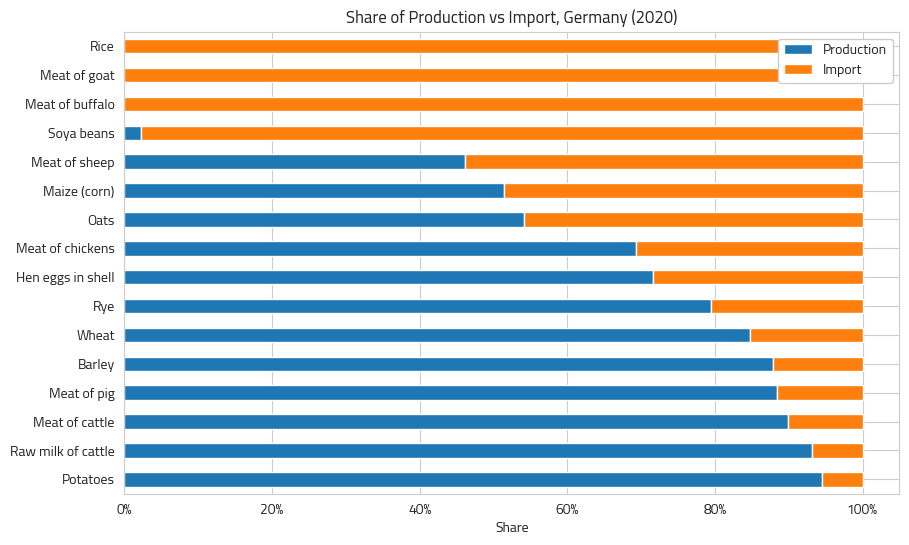

In [48]:
# Filter for 2020
df_trade_prod_ger_2020 = df_trade_prod_ger[df_trade_prod_ger['year'] == 2020]

# Filter for specific items
df_trade_prod_ger_2020_specific = df_trade_prod_ger_2020[df_trade_prod_ger_2020['item'].isin(selected_items)]

# Drop rows with NAs in the production column
df_trade_prod_ger_2020_specific.dropna(subset = 'production_in_t', inplace = True)

# Create a list of food names
custom_names = {
    'Meat of goat, fresh or chilled': 'Meat of goat',
    'Meat of buffalo, fresh or chilled': 'Meat of buffalo',
    'Meat of sheep, fresh or chilled': 'Meat of sheep', 
    'Meat of chickens, fresh or chilled': 'Meat of chickens',
    'Meat of pig with the bone, fresh or chilled': 'Meat of pig',
    'Meat of cattle with the bone, fresh or chilled': 'Meat of cattle', 
    'Hen eggs in shell, fresh': "Hen eggs in shell"
}
# Rename the items
df_trade_prod_ger_2020_specific['item'] = df_trade_prod_ger_2020_specific['item'].replace(custom_names)

# Calculate the share of production and import for each selected product in percentage
df_trade_prod_ger_2020_specific['production_share'] = (df_trade_prod_ger_2020_specific['production_in_t'] / (
        df_trade_prod_ger_2020_specific['production_in_t'] + df_trade_prod_ger_2020_specific['import_quantity'])) * 100
df_trade_prod_ger_2020_specific['import_share'] = (df_trade_prod_ger_2020_specific['import_quantity'] / (
        df_trade_prod_ger_2020_specific['production_in_t'] + df_trade_prod_ger_2020_specific['import_quantity'])) * 100

# Group by product and sum the shares
df_grouped = df_trade_prod_ger_2020_specific.groupby('item')[['production_share', 'import_share']].sum()
df_grouped= df_grouped.sort_values(by='production_share', ascending=False)


# Plotting
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Cairo'
ax = df_grouped.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.title('Share of Production vs Import, Germany (2020)')
plt.xlabel('Share')
ax.set_ylabel('')

# Add '%' sign to x-axis labels without trailing zeros
ax.set_xticklabels([f'{int(x)}%' for x in ax.get_xticks()])


legend_labels = ['Production', 'Import']
legend = plt.legend(legend_labels, framealpha=1) 
plt.savefig('share_production_import_Germany_2020.png', bbox_inches='tight', transparent=True, dpi = 300)
plt.show()

### Emission intensity: production vs import

In [49]:
df_emissions_ger = fs.get_dataframe("SELECT * FROM mk_import_emissions")

In [50]:
df_emissions_ger

,item,import_year,total_import_share,total_import_emission_intensity,total_import_emission_amount
0,Barley,1991,1.0,0.055287,188.540092
1,Barley,1992,1.0,0.059286,228.475877
2,Barley,1993,1.0,0.058420,329.431569
3,Barley,1994,1.0,0.059512,268.575966
4,Barley,1995,1.0,0.060029,286.725613
...,...,...,...,...,...
574,Wheat,2017,1.0,0.070031,673.996001
575,Wheat,2018,1.0,0.070910,686.045472
576,Wheat,2019,1.0,0.069870,704.602759
577,Wheat,2020,1.0,0.069303,536.579921


In [51]:
df_emission_intensity_ger  = pd.merge(df_emissions_ger,df_production_ger_grouped[['item', 'year','emissions_co2eq_combined_in_kt', 'emissions_intensity_combined_in_kg_co2eq_per_kg']], left_on = ['item', 'import_year'], right_on = ['item', 'year'], how = 'left')

In [56]:
df_emission_intensity_ger.head()

,item,import_year,total_import_emission_intensity,total_import_emission_amount,emissions_co2eq_combined_in_kt,emissions_intensity_combined_in_kg_co2eq_per_kg
0,Barley,1991,0.055287,188.540092,855.2610,0.0590
1,Barley,1992,0.059286,228.475877,727.3455,0.0596
2,Barley,1993,0.058420,329.431569,657.1205,0.0597
3,Barley,1994,0.059512,268.575966,647.8720,0.0594
4,Barley,1995,0.060029,286.725613,702.4885,0.0591


In [55]:
df_emission_intensity_ger.drop(columns = ['total_import_share', 'year'], inplace = True)

KeyError: "['total_import_share', 'year'] not found in axis"

In [57]:
df_emission_intensity_ger.rename(columns={'emissions_co2eq_combined_in_kt': 'total_production_emission_amount', 'emissions_intensity_combined_in_kg_co2eq_per_kg': 'total_production_emissions_intensity'}, inplace = True)

In [58]:
df_emission_intensity_ger_2020 = df_emission_intensity_ger[df_emission_intensity_ger['import_year'] == 2020]


In [59]:
df_emission_intensity_ger_2020

,item,import_year,total_import_emission_intensity,total_import_emission_amount,total_production_emission_amount,total_production_emissions_intensity
29,Barley,2020,0.059449,318.661649,629.4280,0.0584
60,"Beans, dry",2020,0.049358,52.108195,NaN,NaN
91,"Hen eggs in shell, fresh",2020,0.693987,429.573496,501.6761,0.5190
122,Maize (corn),2020,0.053999,518.459596,201.2723,0.0501
153,"Meat of cattle with the bone, fresh or chilled",2020,15.860488,11907.505800,16156.0631,14.7949
184,"Meat of chickens, fresh or chilled",2020,0.229655,300.957858,390.2597,0.3661
215,"Meat of goat, fresh or chilled",2020,10.304400,107.719023,29.4428,0.0000
246,"Meat of pig with the bone, fresh or chilled",2020,1.945802,3170.373042,7552.5807,1.4757
277,"Meat of sheep, fresh or chilled",2020,24.524867,6839.960372,475.9323,11.8983
308,Millet,2020,0.059587,29.898265,NaN,NaN


In [60]:
# Rename animal items 
value_mapping = {'Meat of cattle with the bone, fresh or chilled': 'Meat of cattle', 'Meat of chickens, fresh or chilled': 'Meat of chickens', 'Meat of goat, fresh or chilled': 'Meat of goat', 'Meat of pig with the bone, fresh or chilled': 'Meat of pig', 'Meat of sheep, fresh or chilled': 'Meat of sheep'}
df_emission_intensity_ger_2020['item'] = df_emission_intensity_ger_2020['item'].replace(value_mapping)

/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_1844/4170302871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emission_intensity_ger_2020['item'] = df_emission_intensity_ger_2020['item'].replace(value_mapping)


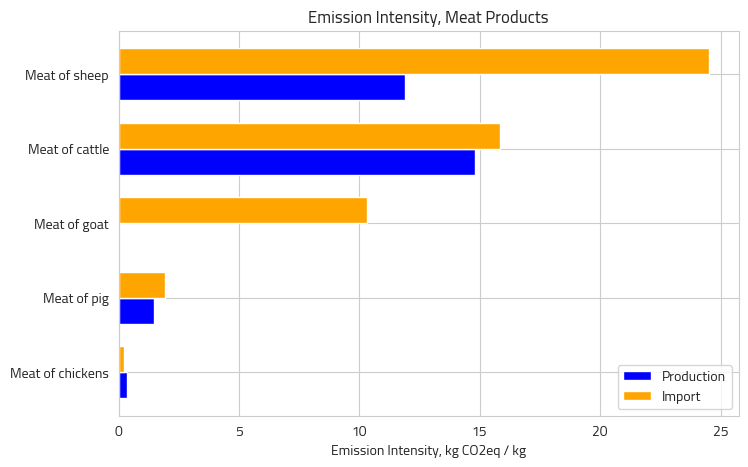

In [64]:
# Function to create horizontal grouped bar chart
def create_grouped_bar_chart(products, title):

    # Filter dataframe based on selected products
    df_selected = df_emission_intensity_ger_2020[df_emission_intensity_ger_2020['item'].isin(products)]

    # Sort the DataFrame based on total_production_emission_amount
    df_selected_sorted = df_selected.sort_values(by='total_import_emission_intensity', ascending=True)

    # Calculate the size based on the number of bars and scale of values
    num_bars = len(df_selected_sorted)
    bar_height = min(0.35, 8 / num_bars)  # Adjust 6 based on your preference for the overall height

    # Calculate the figure size based on the number of bars and scale of values
    fig_size = (8, num_bars * 1)
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'Cairo' 
    plt.figure(figsize=fig_size)

    # Define the index based on the length of the DataFrame
    index = np.arange(len(df_selected_sorted))

    # Plot production emissions
    plt.barh(index, df_selected_sorted['total_production_emissions_intensity'], bar_height, color='blue', label='Production')

    # Plot import emissions
    plt.barh(index + bar_height, df_selected_sorted['total_import_emission_intensity'], bar_height, color='orange', label='Import')

    # Customize the plot
    plt.xlabel('Emission Intensity, kg CO2eq / kg')
    plt.title(title)
    plt.yticks(index + bar_height / 2, df_selected_sorted['item'])
    plt.legend()

    # Show the plot
    filename = title.replace(' ', '_').replace(',', '').replace('/', '_') + '.png'
    plt.savefig(filename, bbox_inches='tight', transparent=True, dpi = 300)
    plt.show()

# Create separate plots for each product list
create_grouped_bar_chart(['Meat of buffalo',
 'Meat of cattle',
 'Meat of chickens',
 'Meat of goat',
 'Meat of pig',
 'Meat of sheep'], 'Emission Intensity, Meat Products')
create_grouped_bar_chart(selected_crops, 'Emission Intensity, Crops')
create_grouped_bar_chart(selected_milk_eggs, 'Emission Intensity, Milk and Eggs')

### Bubble charts

#### Meat emissions

Creating a bubble chart for worldwide meat emissions in 2020.

In [65]:
# Defining new, shorter names for meat food items
def meat_type(food_item):
    if food_item == 'Meat of cattle with the bone, fresh or chilled':
        return 'cattle'
    elif food_item == 'Meat of pig with the bone, fresh or chilled':
        return 'pigs'
    elif food_item == 'Meat of chickens, fresh or chilled':
        return 'chickens'
    elif food_item == 'Meat of buffalo, fresh or chilled':
        return 'buffalo'
    elif food_item == 'Meat of goat, fresh or chilled':
        return 'goat'
    elif food_item == 'Meat of sheep, fresh or chilled':
        return 'sheep'
    return 'meat of other animals'

In [66]:
world_emissions_meat = world_emissions[world_emissions.item_group == 'Meat, Total']
world_emissions_meat['meat_type'] = world_emissions_meat.item.apply(lambda x: meat_type(x))

/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_1844/3320332269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_emissions_meat['meat_type'] = world_emissions_meat.item.apply(lambda x: meat_type(x))


In [67]:
meat = world_emissions_meat.meat_type.unique().tolist()
meat

['buffalo', 'cattle', 'chickens', 'goat', 'pigs', 'sheep']

In [68]:
world_emissions_grouped = world_emissions[['item', 'year', 'emissions_co2eq_combined_in_kt']].groupby(['item', 'year'], as_index=False).agg('mean')

In [69]:
world_emissions_grouped_meat = world_emissions_meat[['meat_type', 'year', 'production_in_t', 'emissions_co2eq_combined_in_kt']].groupby(['meat_type', 'year'], as_index=False).agg('sum')

In [70]:
world_emissions_grouped_meat['meat_type'].unique()

array(['buffalo', 'cattle', 'chickens', 'goat', 'pigs', 'sheep'],
      dtype=object)

In [71]:
world_emissions_grouped_2020 = world_emissions_grouped_meat[world_emissions_grouped_meat['year']== 2020]

In [72]:
world_emissions_grouped_2020_sorted = world_emissions_grouped_2020.sort_values(by='emissions_co2eq_combined_in_kt', ascending=True)

In [73]:
world_emissions_grouped_2020_sorted['emissions_co2eq_combined_in_kt'] = \
    world_emissions_grouped_2020_sorted['emissions_co2eq_combined_in_kt'].round()

In [74]:
world_emissions_grouped_2020_sorted['meat_type'].unique()

array(['chickens', 'pigs', 'goat', 'sheep', 'buffalo', 'cattle'],
      dtype=object)

In [75]:
world_emissions_grouped_2020_sorted

,meat_type,year,production_in_t,emissions_co2eq_combined_in_kt
179,chickens,2020,1.204613e+08,64444.0
299,pigs,2020,1.082522e+08,196697.0
239,goat,2020,6.287978e+06,210282.0
359,sheep,2020,9.817036e+06,239828.0
59,buffalo,2020,4.279510e+06,254911.0
119,cattle,2020,7.159749e+07,2037619.0


In [76]:
# compute circle positions:
circles = circlify.circlify(
    world_emissions_grouped_2020_sorted['emissions_co2eq_combined_in_kt'].tolist(),
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

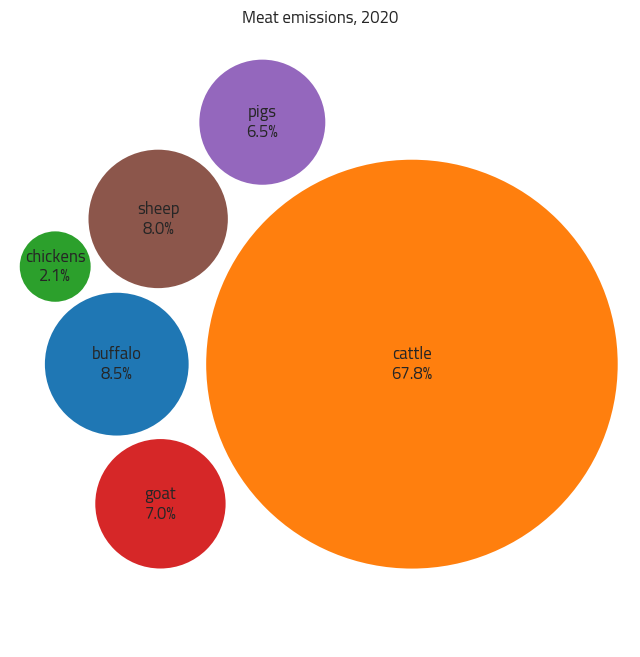

In [79]:
# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(8,8))

# Create a list of colors for each label
colors = ['#2ca02c', '#9467bd', '#d62728', '#8c564b', '#1f77b4','#ff7f0e']

# Create a dictionary of font sizes for each label 
font_sizes = {
    'cattle': 12,
    'pigs': 12,
    'chickens': 12,
    'buffalo':12,
    'goat': 12,
    'sheep':12
}

# Remove axes
ax.axis('off')

# Title
ax.set_title('Meat emissions, 2020')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = world_emissions_grouped_2020_sorted['meat_type']

# Create a list of emission shares in % 
percentages = [2.1, 6.5, 7.0, 8.0, 8.5, 67.8]

# print circles
for circle, label, color, percentage in zip(circles, labels, colors, percentages):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r*0.95, alpha=1, linewidth=2, facecolor=color, edgecolor="white"))

    # Concatenate label with percentage
    label_with_percentage = f"{label}\n{percentage:.1f}%"
    ax.annotate(label_with_percentage, (circle.x, circle.y), ha='center', va='center', fontsize=font_sizes.get(label, 12))

plt.savefig('meat_emissions_2020.png', bbox_inches='tight', transparent=True, dpi = 300)
plt.show()

#### Crop emissions

In [80]:
def crop_type(food_item):
    if food_item == 'Rice':
        return 'rice'
    elif food_item == 'Wheat':
        return 'wheat'
    elif food_item == 'Maize (corn)':
        return 'maize'
    elif food_item == 'Sugar cane':
        return 'sugar cane'
    return 'other crops'

world_emissions_crops = world_emissions[world_emissions.item_category == 'Crops, primary']
world_emissions_crops['crop_type'] = world_emissions_crops.item.apply(lambda x: crop_type(x))

/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_1844/2676505879.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_emissions_crops['crop_type'] = world_emissions_crops.item.apply(lambda x: crop_type(x))


In [81]:
crops = world_emissions_crops.crop_type.unique().tolist()
crops

['other crops', 'maize', 'rice', 'sugar cane', 'wheat']

In [82]:
world_emissions_grouped_crops = world_emissions_crops[['crop_type', 'year', 'production_in_t', 'emissions_co2eq_combined_in_kt']].groupby(['crop_type', 'year'], as_index=False).agg('sum')

In [83]:
world_emissions_grouped_crops.head()

,crop_type,year,production_in_t,emissions_co2eq_combined_in_kt
0,maize,1961,205027246.0,20007.5659
1,maize,1962,204876646.0,19763.0345
2,maize,1963,220228125.0,20917.0883
3,maize,1964,215172401.0,20666.8176
4,maize,1965,226544131.0,20954.3950


In [84]:
world_emissions_grouped_crops_2020 = world_emissions_grouped_crops[world_emissions_grouped_crops['year']== 2020]

In [85]:
world_emissions_grouped_crops_2020_sorted = world_emissions_grouped_crops_2020.sort_values(by='emissions_co2eq_combined_in_kt', ascending=True)

In [86]:
world_emissions_grouped_crops_2020_sorted.head()

,crop_type,year,production_in_t,emissions_co2eq_combined_in_kt
239,sugar cane,2020,1.864663e+09,1618.9953
119,other crops,2020,1.041740e+09,47502.7605
299,wheat,2020,7.569496e+08,57786.9862
59,maize,2020,1.162998e+09,67337.5887
179,rice,2020,7.692280e+08,816502.8020


In [87]:
# compute circle positions:
circles = circlify.circlify(
    world_emissions_grouped_crops_2020_sorted['emissions_co2eq_combined_in_kt'].tolist(),
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

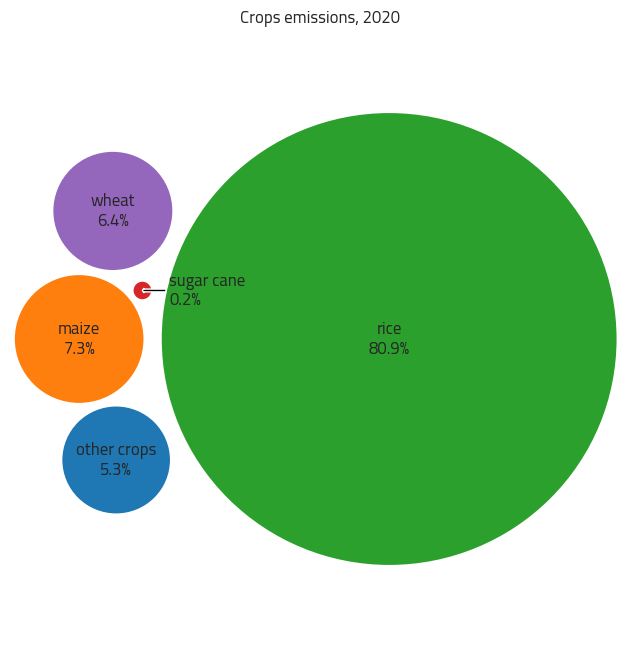

In [88]:
# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(8,8))

# Create a list of colors for each label
colors = ['#d62728','#1f77b4','#9467bd','#ff7f0e', '#2ca02c']


# Create a dictionary of font sizes for each label 
font_sizes = {
    'rice': 12,
    'maize': 12,
    'wheat': 12,
    'other crops': 12, 
    'sugar cane': 12
}

# Remove axes
ax.axis('off')

# Title
ax.set_title('Crops emissions, 2020')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = world_emissions_grouped_crops_2020_sorted['crop_type']

# Create a list of emission shares in % 
percentages = [0.2, 5.3, 6.4, 7.3, 80.9 ]

# print circles
for circle, label, color, percentage in zip(circles, labels, colors, percentages):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r*0.95, alpha=1, linewidth=2, facecolor=color, edgecolor="white"))

    # Concatenate label with percentage
    label_with_percentage = f"{label}\n{percentage:.1f}%"

    #ax.annotate(label_with_percentage, (circle.x, circle.y), ha='center', va='center', fontsize=font_sizes.get(label, 10))
    
    # Use annotate with xytext to place the label on the right side of the bubble for "sugar cane" only
    if label == 'sugar cane':
        ax.annotate(label_with_percentage, (circle.x, circle.y), xytext=(circle.x + r*2.5, circle.y),
                    ha='left', va='center', fontsize=font_sizes.get(label, 10), arrowprops=dict(facecolor='black', width=2, headwidth=3, headlength =1))
    else:
        ax.annotate(label_with_percentage, (circle.x, circle.y), ha='center', va='center', fontsize=font_sizes.get(label, 10))

plt.savefig('crops_emissions_2020.png', bbox_inches='tight', transparent=True, dpi = 300)
plt.show()



### Scatterplot emission intensity & import amount

In [109]:
#Create a data frame
df_import_amount_emissions_ger = pd.merge(df_trade_prod_ger[['item', 'year', 'import_quantity']], df_emissions_ger[['item', 'import_year','total_import_emission_intensity', 'total_import_emission_amount']], left_on = ['item', 'year'], right_on = ['item', 'import_year'], how = 'left')

In [110]:
# Filter for 2020
df_import_amount_emissions_ger = df_import_amount_emissions_ger[df_import_amount_emissions_ger['year']==2020]

In [101]:
def create_grouped_scatterplot(products, title, name_mapping=None):
    sns.set_style("whitegrid")
    plt.figure(figsize=(6, 6))
    plt.rcParams['font.family'] = 'Cairo'
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_selected = df_import_amount_emissions_ger[df_import_amount_emissions_ger['item'].isin(products)].copy()
    df_selected.dropna(subset=['total_import_emission_amount'], inplace=True)
    
    # Use the provided name_mapping or create a default mapping
    if name_mapping is None:
        name_mapping = {item: item for item in products}
    
    # Rename items in the DataFrame
    df_selected['item'] = df_selected['item'].map(name_mapping)

    # Create a color mapping for each unique product
    unique_products = df_selected['item'].unique()
    colors = sns.color_palette("husl", n_colors=len(unique_products))
    color_mapping = dict(zip(unique_products, colors))

    # Use the color mapping for both scatterplot and legend
    sns.scatterplot(data=df_selected, x="import_quantity", y="total_import_emission_intensity",
                    size='total_import_emission_amount', hue='item', sizes=(50, 1000),
                    palette=color_mapping)
    
    plt.xlabel("Import, Mt")
    plt.ylabel("Emission Intensity, kg CO2eq / kg")

    # Create custom legend using the color mapping
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[item], markersize=8, label=item)
                      for item in unique_products]

    # Add a transparent background to the legend
    legend = plt.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc='upper right', fontsize=10, scatterpoints=1)
    legend.get_frame().set_alpha(0.5)  # Set legend background transparency

    # Save the graph with a transparent background
    filename = title.replace(' ', '_').replace(',', '').replace('/', '_') + '.png'
    plt.savefig(filename, bbox_inches='tight', transparent=True, dpi = 300)
    plt.show()

In [93]:
meat_and_milk = ['Meat of buffalo, fresh or chilled',
 'Meat of cattle with the bone, fresh or chilled',
 'Meat of chickens, fresh or chilled',
 'Meat of goat, fresh or chilled',
 'Meat of pig with the bone, fresh or chilled',
 'Meat of sheep, fresh or chilled',
 'Hen eggs in shell, fresh', 
 'Raw milk of cattle', 
 'Raw milk of sheep']

In [94]:
crops_and_vegetables = ['Maize (corn)',
 'Wheat',
 'Sorghum',
 'Potatoes',
 'Rye',
 'Millet',
 'Soya beans',
 'Barley',
 'Oats',
 'Sugar cane',
 'Beans, dry', 
 'Rice']

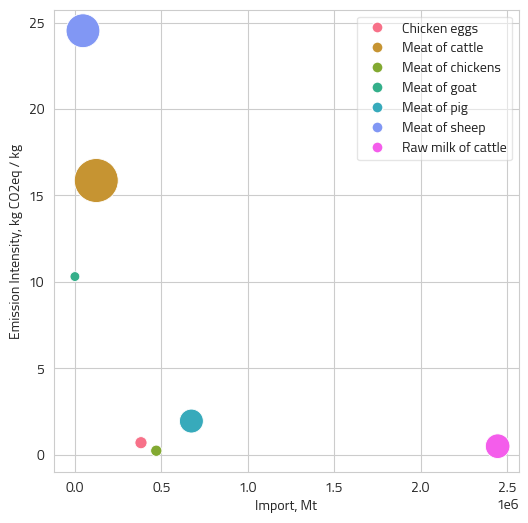

In [111]:
# Create a scatterplot for animal products
name_mapping_animal_products = {'Meat of buffalo, fresh or chilled':'Meat of buffalo',
                                 'Meat of cattle with the bone, fresh or chilled':'Meat of cattle',
                                   'Meat of chickens, fresh or chilled':'Meat of chickens',
                                     'Meat of goat, fresh or chilled':'Meat of goat',
                                       'Meat of pig with the bone, fresh or chilled':'Meat of pig',
                                         'Meat of sheep, fresh or chilled':'Meat of sheep',
                                           'Hen eggs in shell, fresh':'Chicken eggs',
                                             'Raw milk of cattle':'Raw milk of cattle',
                                               'Raw milk of sheep':'Raw milk of sheep'}

create_grouped_scatterplot(meat_and_milk, 'Emissions animal products 2020', name_mapping_animal_products)

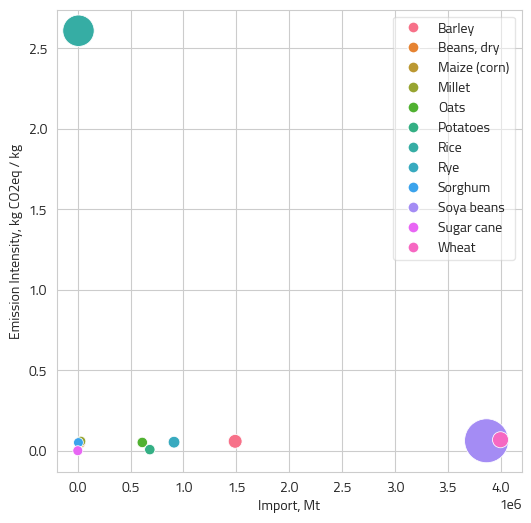

In [103]:
# Create a scatterplot for crops and vegetables
create_grouped_scatterplot(crops_and_vegetables, 'Emissions crops and vegetables 2020')

In [113]:
df_trade_ger_grouped = df_trade_ger.groupby(['reporting_country', 'partner_country', 'year', 'item']).sum().reset_index()

In [114]:
df_trade_ger_grouped.head()

,reporting_country,partner_country,year,item,item_code,unit,export_quantity,export_value,import_quantity,import_value
0,Germany,Afghanistan,1991,Apples,1030,1000 USDt,3.0,4.0,0.0,0.0
1,Germany,Afghanistan,1991,"Beer of barley, malted",102,1000 USDt,147.0,99.0,0.0,0.0
2,Germany,Afghanistan,1991,Beeswax,2366,1000 USDt,4.0,17.0,0.0,0.0
3,Germany,Afghanistan,1991,Chocolate products nes,1332,1000 USDt,1.0,1.0,0.0,0.0
4,Germany,Afghanistan,1991,Cigarettes,1656,1000 USDt,82.0,576.0,0.0,0.0


In [115]:
df_emissions_ger.head()

,item,import_year,total_import_share,total_import_emission_intensity,total_import_emission_amount
0,Barley,1991,1.0,0.055287,188.540092
1,Barley,1992,1.0,0.059286,228.475877
2,Barley,1993,1.0,0.058420,329.431569
3,Barley,1994,1.0,0.059512,268.575966
4,Barley,1995,1.0,0.060029,286.725613


In [117]:
df_prod_emis_grouped = df_prod_emis.groupby(['country', 'year','item']).sum().reset_index()

In [118]:
df_prod_emis_grouped.head()

,country,year,item,continent,subcontinent,special_area,population,item_code,item_group,item_category,...,emissions_co2eq_calc_in_kt,emissions_intensity_calc_in_kg_co2eq_per_kg,source_emissions,emissions_co2eq_in_kt,emissions_intensity_in_kg_co2eq_per_kg,production_emissions_in_t,emissions_co2eq_combined_in_kt,emissions_intensity_combined_in_kg_co2eq_per_kg,prod_pop,emis_pop
0,Afghanistan,1961,Apples,Asia,Southern Asia,Land Locked Developing Countries,8790140,515,Fruit Primary,"Crops, primary",...,0.0000,0.00,0,0.0,0.0,0.0,0.0000,0.00,0.001718,0.000000
1,Afghanistan,1961,Apricots,Asia,Southern Asia,Land Locked Developing Countries,8790140,526,Fruit Primary,"Crops, primary",...,0.0000,0.00,0,0.0,0.0,0.0,0.0000,0.00,0.003640,0.000000
2,Afghanistan,1961,Barley,Asia,Southern Asia,Land Locked Developing Countries,8790140,44,"Cereals, primary","Crops, primary",...,30.2365,0.08,FAO TIER 1,0.0,0.0,0.0,30.2365,0.08,0.043003,0.000003
3,Afghanistan,1961,Butter and ghee of sheep milk,Asia,Southern Asia,Land Locked Developing Countries,8790140,983,Butter and Ghee,Livestock processed,...,0.0000,0.00,0,0.0,0.0,0.0,0.0000,0.00,0.000467,0.000000
4,Afghanistan,1961,Butter of cow milk,Asia,Southern Asia,Land Locked Developing Countries,8790140,886,Butter and Ghee,Livestock processed,...,0.0000,0.00,0,0.0,0.0,0.0,0.0000,0.00,0.000796,0.000000


In [119]:
df_production_trade = pd.merge(df_trade_ger_grouped, df_prod_emis_grouped[['country', 'year', 'item','emissions_intensity_combined_in_kg_co2eq_per_kg']], left_on =['partner_country', 'year', 'item'], right_on = ['country', 'year', 'item'], how = 'left')

#### Rice

In [ ]:
# Filter for selected items
rice = df_production_trade[df_production_trade['item']=='Rice']

In [ ]:
# Filter for 2020
rice_2020 = rice[rice['year']==2020]

In [ ]:
rice_2020

In [ ]:
# Drop rows where emission intensity is NA
rice_2020.dropna(subset=['emissions_intensity_combined_in_kg_co2eq_per_kg'], inplace= True)

In [ ]:
rice_2020

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Sort the filtered dataframe by the import_quantity column in descending order
rice_2020_sorted = rice_2020.sort_values(by='import_quantity', ascending=False)

rice_2020_sorted = rice_2020_sorted.head(10)

# Define emission intensity ranges and corresponding colors
emission_intensity_ranges = [(0, 1), (1, 2), (2, 5), (5, float('inf'))]
colors = ['green', 'yellow', 'orange', 'red']

# Create a custom color mapping based on emission intensity ranges
color_mapping = {val: color for val, color in zip(emission_intensity_ranges, colors)}

# Map the emission intensity values to corresponding colors
rice_2020_sorted['color'] = pd.cut(
    rice_2020_sorted['emissions_intensity_combined_in_kg_co2eq_per_kg'],
    bins=[range[0] for range in emission_intensity_ranges] + [float('inf')],
    labels=colors,
    right=False
)

# Plot the main bars using barplot with custom color mapping
bars = sns.barplot(
    x="import_quantity",
    y="partner_country",
    data=rice_2020_sorted,
    estimator=sum,
    errorbar=None,
    palette=rice_2020_sorted['color'],  # Use the 'color' column as the palette
)

# Creat custom labels for the y-axis
custom_labels = ['Italy', 'Netherlands', 'Hungary', 'Denmark', 'Spain', 'Poland', 'Czechia', 'Belgium', 'Greece', 'Portugal']
bars.set_yticklabels(custom_labels)

# Create custom legend
legend_labels = [f'{range[0]}-{range[1]}' if range[1] != float('inf') else f'{range[0]}+' for range in emission_intensity_ranges]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
plt.legend(legend_handles, legend_labels, bbox_to_anchor=(1, 0.8), title='Emission Intensity, kg CO2eq', loc='upper right')

# Set labels and title
plt.xlabel('Import, t')
plt.ylabel('')
plt.title('Top-10 Import Partners')

# Display the plot
plt.show()


#### Soya beans

In [ ]:
# Filter for selected items
soy_beans = df_production_trade[df_production_trade['item']=='Soya beans']

In [ ]:
# Filter for 2020
soy_beans_2020 = soy_beans[soy_beans['year']==2020]

In [ ]:
# Drop rows where emission intensity is NA
soy_beans_2020.dropna(subset=['emissions_intensity_combined_in_kg_co2eq_per_kg'], inplace= True)

In [ ]:
# Create a plot for soy beans
# Set the figure size
plt.figure(figsize=(10, 7))

# Filter the dataframe where import_quantity is greater than 30
soy_beans_2020_filtered = soy_beans_2020[soy_beans_2020['import_quantity'] > 0]

# Sort the filtered dataframe by the import_quantity column in descending order
soy_beans_2020_sorted = soy_beans_2020_filtered.sort_values(by='import_quantity', ascending=False)

# Define emission intensity ranges and corresponding colors
emission_intensity_ranges = [(0, 1), (1, 2), (2, 5), (5, float('inf'))]
colors = ['green', 'yellow', 'orange', 'red']

# Create a custom color mapping based on emission intensity ranges
color_mapping = {val: color for val, color in zip(emission_intensity_ranges, colors)}

# Map the emission intensity values to corresponding colors
soy_beans_2020_sorted['color'] = pd.cut(
    soy_beans_2020_sorted['emissions_intensity_combined_in_kg_co2eq_per_kg'],
    bins=[range[0] for range in emission_intensity_ranges] + [float('inf')],
    labels=colors,
    right=False
)

# Plot the main bars using barplot with custom color mapping
bars = sns.barplot(
    x="import_quantity",
    y="partner_country",
    data=soy_beans_2020_sorted,
    estimator=sum,
    errorbar=None,
    palette=soy_beans_2020_sorted['color'],  # Use the 'color' column as the palette
)

# Create custom legend
legend_labels = [f'{range[0]}-{range[1]}' if range[1] != float('inf') else f'{range[0]}+' for range in emission_intensity_ranges]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
plt.legend(legend_handles, legend_labels, bbox_to_anchor=(1, 0.8), title='Emission Intensity Ranges', loc='upper right')

# Set labels and title
plt.xlabel('Import Quantity')
plt.ylabel('Partner Country')
plt.title('Soya beans, Emissions per import country')

# Display the plot
plt.show()


#### Sheep meat

In [121]:
# Filter for selected items
sheep_meat = df_production_trade[df_production_trade['item']=='Meat of sheep, fresh or chilled']

In [122]:
# Filter for 2020
sheep_meat_2020 = sheep_meat[sheep_meat['year']==2020]

In [123]:
# Drop rows where emission intensity is NA
sheep_meat_2020.dropna(subset=['emissions_intensity_combined_in_kg_co2eq_per_kg'], inplace= True)

/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_1844/3804388838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sheep_meat_2020.dropna(subset=['emissions_intensity_combined_in_kg_co2eq_per_kg'], inplace= True)


In [124]:
percentiles = np.percentile(sheep_meat_2020['emissions_intensity_combined_in_kg_co2eq_per_kg'], [0, 20, 40, 60, 80, 100])
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

In [125]:
percentiles

array([  0.     ,  14.5807 ,  24.93706,  36.86094,  50.7784 , 635.0139 ])

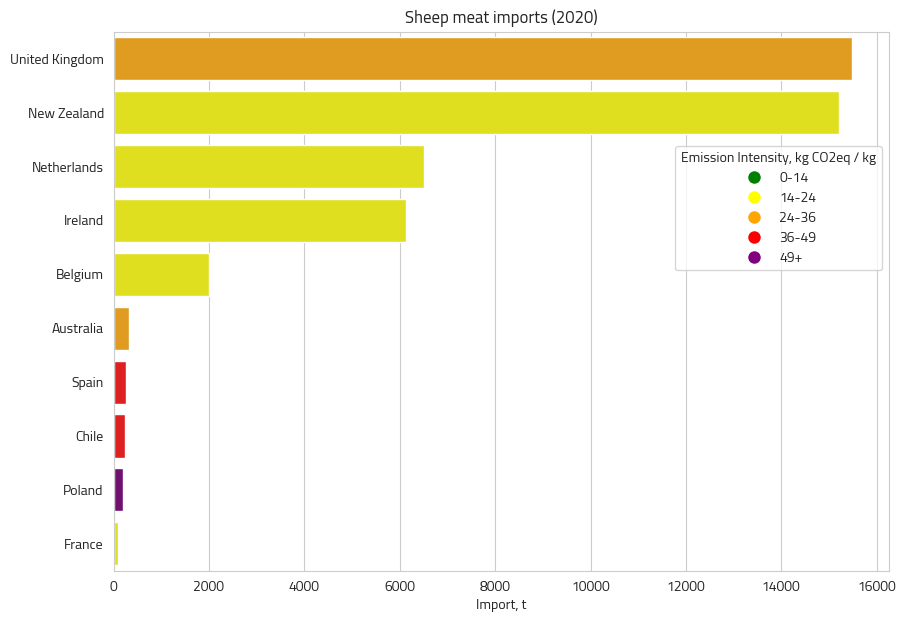

In [127]:
# Create a plot for sheep meat
# Set the figure size
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Cairo'

# Sort the filtered dataframe by the import_quantity column in descending order
sheep_meat_2020_sorted = sheep_meat_2020.sort_values(by='import_quantity', ascending=False)
sheep_meat_2020_sorted = sheep_meat_2020_sorted.head(10)

# Define emission intensity ranges and corresponding colors
emission_intensity_ranges = [(0, 14), (14, 24), (24, 36),(36, 49), (49, float('inf'))]
colors = ['green', 'yellow', 'orange', 'red', 'purple']

# Create a custom color mapping based on emission intensity ranges
color_mapping = {val: color for val, color in zip(emission_intensity_ranges, colors)}

# Map the emission intensity values to corresponding colors
sheep_meat_2020_sorted['color'] = pd.cut(
    sheep_meat_2020_sorted['emissions_intensity_combined_in_kg_co2eq_per_kg'],
    bins=[range[0] for range in emission_intensity_ranges] + [float('inf')],
    labels=colors,
    right=False
)

# Plot the main bars using barplot with custom color mapping
bars = sns.barplot(
    x="import_quantity",
    y="partner_country",
    data=sheep_meat_2020_sorted,
    estimator=sum,
    errorbar=None,
    palette=sheep_meat_2020_sorted['color'],  # Use the 'color' column as the palette
)

# Creat custom labels for the y-axis
custom_labels = ['United Kingdom', 'New Zealand', 'Netherlands', 'Ireland', 'Belgium', 'Australia', 'Spain', 'Chile', 'Poland', 'France']
bars.set_yticklabels(custom_labels)

# Create custom legend
legend_labels = [f'{range[0]}-{range[1]}' if range[1] != float('inf') else f'{range[0]}+' for range in emission_intensity_ranges]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
plt.legend(legend_handles, legend_labels, bbox_to_anchor=(1, 0.8), title='Emission Intensity, kg CO2eq / kg', loc='upper right')

# Set labels and title
plt.xlabel('Import, t')
plt.ylabel('')
plt.title('Sheep meat imports (2020)')

# Save the graph with a transparent background
plt.savefig('sheep_meat_imports_2020.png', bbox_inches='tight', transparent=True, dpi=300)
# Display the plot
plt.show()
